# 선행 논문 재현
선행 논문에서 수행했던 연구 방법을 한 우수 농가의 데이터를 사용하여 재현해본다.

In [1]:
import os
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import getCode

serviceKey = '923f389b2ca44295a07f14d1828aee0e'

In [178]:
print(getCode("TI"))
print(getCode("CI"))

내부온도
내부CO2


In [2]:
# Wonhee's special methods to display large DataFrames
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [5]:
env = pd.read_csv('data/outstanding/envdatarqst.csv', index_col=0)
env.head()

,id,inTp,inHd,measDtStr,otmsuplyqy,acSlrdQy,frmhsId,cunt,ph,outTp,outWs,daysuplyqy,inCo2,ec
0,81,24.933333,99.99,20170815000000,0.0,0.0,81,0.0,0.0,22.411667,0.150000,0.0,408.750000,0.0
1,81,24.546667,99.98,20170815010000,0.0,0.0,81,0.0,0.0,22.260000,0.021667,0.0,396.000000,0.0
2,81,23.873333,99.95,20170815020000,0.0,0.0,81,0.0,0.0,22.280000,0.043333,0.0,379.266667,0.0
3,81,27.138333,100.00,20170814170000,0.0,0.0,81,0.0,0.0,24.446667,0.038333,0.0,383.033333,0.0
4,81,26.143333,100.00,20170814180000,0.0,0.0,81,0.0,0.0,23.961667,0.028333,0.0,383.500000,0.0


In [7]:
prd = pd.read_csv('data/outstanding/prddatarqst.csv', index_col=0)
prd.head()

,id,frmYear,frmMonth,frmAr,frmhsId,outtrn,frmWeek
0,81,2017,8,2700.0,81,0.0,31
1,81,2017,8,2700.0,81,0.0,32
2,81,2017,8,2700.0,81,0.0,33
3,81,2017,8,2700.0,81,0.0,34
4,81,2017,8,2700.0,81,0.0,35


대상 농가는 평균 생산량이 가장 높은 28번 농가로 한다

In [53]:
prd[['outtrn']].groupby(prd['id']).mean().sort_values(by=['outtrn'], ascending=False).head()

,outtrn
id,
28,7105.705882
326,6316.408163
349,5846.638889
9,5564.826087
81,4875.760000


In [54]:
df_interact(prd[prd['id']==28])

interactive(children=(IntSlider(value=0, description='row', max=51, step=7), Output()), _dom_classes=('widget-…

(51 rows, 7 columns) total


전처리에 앞서 평균 outtrn이 0인 농가는 drop한다. → env에는 없었다!

In [100]:
temp = prd['outtrn'].groupby(prd['id']).mean().to_frame()
zero_outtrn_index = list(temp[temp['outtrn']==0].index)
zero_outtrn_id = env[env['id'].isin(zero_outtrn_index)]
zero_outtrn_id

,id,inTp,inHd,measDtStr,otmsuplyqy,acSlrdQy,frmhsId,cunt,ph,outTp,outWs,daysuplyqy,inCo2,ec


## 1. 전처리
데이터(수확량 및 각 환경변수)를 일주일 단위로 가공한다.

In [8]:
prd28=prd[prd['id']==28]
prd28

,id,frmYear,frmMonth,frmAr,frmhsId,outtrn,frmWeek
0,28,2017,8,2960.0,28,0.0,32
1,28,2017,8,2960.0,28,0.0,33
2,28,2017,8,2960.0,28,0.0,34
3,28,2017,8,2960.0,28,0.0,35
4,28,2017,9,2960.0,28,0.0,36
5,28,2017,9,2960.0,28,0.0,37
6,28,2017,9,2960.0,28,0.0,38
7,28,2017,9,2960.0,28,0.0,39
8,28,2017,10,2960.0,28,0.0,40
9,28,2017,10,2960.0,28,0.0,41


In [9]:
env28=env[env['id']==28]
env28.head()

,id,inTp,inHd,measDtStr,otmsuplyqy,acSlrdQy,frmhsId,cunt,ph,outTp,outWs,daysuplyqy,inCo2,ec
0,28,24.50,78.38,20170907110000,0.0,0.0,28,0.0,0.0,23.68,0.0,0.0,370.03,0.0
1,28,27.02,68.41,20170907120000,0.0,0.0,28,0.0,0.0,25.52,0.0,0.0,352.00,0.0
2,28,27.92,65.38,20170907130000,0.0,0.0,28,0.0,0.0,25.98,0.0,0.0,365.03,0.0
3,28,28.92,61.43,20170907140000,0.0,0.0,28,0.0,0.0,27.40,0.0,0.0,350.43,0.0
4,28,28.21,65.21,20170907150000,0.0,0.0,28,0.0,0.0,27.10,0.0,0.0,364.00,0.0


In [179]:
env28

,id,inTp,inHd,measDtStr,otmsuplyqy,acSlrdQy,frmhsId,cunt,ph,outTp,outWs,daysuplyqy,inCo2,ec,date,hours
0,28,24.50,78.38,20170907110000,0.0,0.0,28,0.0,0.0,23.68,0.0,0.0,370.03,0.0,20170907,110000
1,28,27.02,68.41,20170907120000,0.0,0.0,28,0.0,0.0,25.52,0.0,0.0,352.00,0.0,20170907,120000
2,28,27.92,65.38,20170907130000,0.0,0.0,28,0.0,0.0,25.98,0.0,0.0,365.03,0.0,20170907,130000
3,28,28.92,61.43,20170907140000,0.0,0.0,28,0.0,0.0,27.40,0.0,0.0,350.43,0.0,20170907,140000
4,28,28.21,65.21,20170907150000,0.0,0.0,28,0.0,0.0,27.10,0.0,0.0,364.00,0.0,20170907,150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8431,28,32.87,100.00,20180723190000,0.0,0.0,28,0.0,0.0,32.70,0.0,0.0,336.00,0.0,20180723,190000
8432,28,29.77,100.00,20180723200000,0.0,0.0,28,0.0,0.0,29.50,0.0,0.0,347.00,0.0,20180723,200000
8433,28,28.80,100.00,20180723210000,0.0,0.0,28,0.0,0.0,28.80,0.0,0.0,360.00,0.0,20180723,210000
8434,28,28.30,100.00,20180723220000,0.0,0.0,28,0.0,0.0,28.40,0.0,0.0,379.00,0.0,20180723,220000


In [10]:
def splitstr1(series):
    return str(series)[:8]
def splitstr2(series):
    return str(series)[8:]

In [11]:
env28['date']=env28['measDtStr'].agg(splitstr1)
env28['hours']=env28['measDtStr'].agg(splitstr2)

c:\users\youjeongsue\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\youjeongsue\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
env28.head()

,id,inTp,inHd,measDtStr,otmsuplyqy,acSlrdQy,frmhsId,cunt,ph,outTp,outWs,daysuplyqy,inCo2,ec,date,hours
0,28,24.50,78.38,20170907110000,0.0,0.0,28,0.0,0.0,23.68,0.0,0.0,370.03,0.0,20170907,110000
1,28,27.02,68.41,20170907120000,0.0,0.0,28,0.0,0.0,25.52,0.0,0.0,352.00,0.0,20170907,120000
2,28,27.92,65.38,20170907130000,0.0,0.0,28,0.0,0.0,25.98,0.0,0.0,365.03,0.0,20170907,130000
3,28,28.92,61.43,20170907140000,0.0,0.0,28,0.0,0.0,27.40,0.0,0.0,350.43,0.0,20170907,140000
4,28,28.21,65.21,20170907150000,0.0,0.0,28,0.0,0.0,27.10,0.0,0.0,364.00,0.0,20170907,150000


In [13]:
mean_env=env28.groupby('date').mean()
mean_env

,id,inTp,inHd,measDtStr,otmsuplyqy,acSlrdQy,frmhsId,cunt,ph,outTp,outWs,daysuplyqy,inCo2,ec
date,,,,,,,,,,,,,,
20170801,28,29.137917,80.090417,20170801115000,0.0,0.0,28,0.0,0.0,27.695833,0.0,0.0,375.768333,0.0
20170802,28,30.016667,81.725833,20170802115000,0.0,0.0,28,0.0,0.0,28.621667,0.0,0.0,392.477917,0.0
20170803,28,30.667083,73.404583,20170803115000,0.0,0.0,28,0.0,0.0,29.119583,0.0,0.0,380.745417,0.0
20170804,28,30.858750,76.167500,20170804115000,0.0,0.0,28,0.0,0.0,29.441250,0.0,0.0,379.623333,0.0
20170805,28,32.680000,74.027083,20170805115000,0.0,0.0,28,0.0,0.0,31.093750,0.0,0.0,383.855833,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20180719,28,28.938750,98.423750,20180719115000,0.0,0.0,28,0.0,0.0,28.390417,0.0,0.0,386.097500,0.0
20180720,28,29.377500,98.373333,20180720115000,0.0,0.0,28,0.0,0.0,29.032083,0.0,0.0,379.248333,0.0
20180721,28,30.003333,98.239583,20180721115000,0.0,0.0,28,0.0,0.0,29.832917,0.0,0.0,391.969583,0.0


In [14]:
week=[]
for i in range(51):
    week += [i]*7
week=week[:-4]

In [15]:
mean_env['week']=week

In [87]:
mean_week_env = mean_env.groupby('week').mean()
mean_week_env.head()

,id,inTp,inHd,measDtStr,otmsuplyqy,acSlrdQy,frmhsId,cunt,ph,outTp,outWs,daysuplyqy,inCo2,ec
week,,,,,,,,,,,,,,
0,28.0,31.466548,76.712738,2.017080e+13,0.0,0.0,28.0,0.0,0.0,29.368095,0.0,0.0,386.766012,0.0
1,28.0,27.139821,87.740893,2.017081e+13,0.0,0.0,28.0,0.0,0.0,25.916488,0.0,0.0,372.866012,0.0
2,28.0,26.691071,88.976071,2.017082e+13,0.0,0.0,28.0,0.0,0.0,25.385774,0.0,0.0,368.967857,0.0
3,28.0,27.162679,78.676071,2.017083e+13,0.0,0.0,28.0,0.0,0.0,25.684583,0.0,0.0,386.796250,0.0
4,28.0,22.679226,73.422976,2.017087e+13,0.0,0.0,28.0,0.0,0.0,21.402381,0.0,0.0,385.721786,0.0


In [88]:
del mean_week_env['id']
del mean_week_env['measDtStr']
del mean_week_env['daysuplyqy']
del mean_week_env['outWs']
del mean_week_env['acSlrdQy']
del mean_week_env['frmhsId']

In [133]:
columns=list(mean_week_env.columns)
columns

['inTp', 'inHd', 'otmsuplyqy', 'cunt', 'ph', 'outTp', 'inCo2', 'ec']

In [115]:
corr_result=pd.DataFrame(columns=['x1','x2','x3','x4','x5','x6','x7','x8','x9'])

#globals()로 변수별 df를 0~7로 저장
for j in range(len(columns)):
    globals()['df{}'.format(j)]=pd.DataFrame(columns=['y','x','x1','x2','x3','x4','x5','x6','x7','x8','x9'])
    globals()['df{}'.format(j)]['y']=prd28['outtrn'][:-1]#마지막에 0있는거 빼줌
    var=list(globals()['df{}'.format(j)].columns)
    for i in range(10):
        temp=[nan]*i
        temp.extend(mean_week_env[columns[j]][:-i-1])
        globals()['df{}'.format(j)][var[i+1]]=temp
    globals()['df{}'.format(j)][globals()['df{}'.format(j)] == 0] = np.nan
    corr=globals()['df{}'.format(j)].corr(method='pearson') #TODO: pearson -> spearman
    corr_result.loc[columns[j]]=corr['y'][2:]

In [172]:
df1

,y,x,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,NaN,76.712738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,87.740893,76.712738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,88.976071,87.740893,76.712738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,78.676071,88.976071,87.740893,76.712738,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,73.422976,78.676071,88.976071,87.740893,76.712738,NaN,NaN,NaN,NaN,NaN
5,NaN,91.452679,73.422976,78.676071,88.976071,87.740893,76.712738,NaN,NaN,NaN,NaN
6,NaN,84.053274,91.452679,73.422976,78.676071,88.976071,87.740893,76.712738,NaN,NaN,NaN
7,NaN,87.398095,84.053274,91.452679,73.422976,78.676071,88.976071,87.740893,76.712738,NaN,NaN
8,NaN,88.665952,87.398095,84.053274,91.452679,73.422976,78.676071,88.976071,87.740893,76.712738,NaN
9,NaN,89.979048,88.665952,87.398095,84.053274,91.452679,73.422976,78.676071,88.976071,87.740893,76.712738


In [116]:
corr_result

,x1,x2,x3,x4,x5,x6,x7,x8,x9
inTp,-0.149128,-0.190219,-0.134696,-0.123682,-0.053802,0.003211,0.017349,0.025906,0.149556
inHd,-0.033854,-0.042295,-0.052637,0.006782,0.008149,0.025389,0.150968,-0.144128,-0.108124
otmsuplyqy,-0.127007,-0.454098,-0.214755,-0.001845,0.136110,0.105204,0.103839,0.191669,-0.444572
cunt,0.206688,0.243349,-0.106244,0.467638,0.154039,-0.050875,-0.108972,0.141043,-0.353725
ph,-0.231749,-0.199727,-0.289524,0.111969,0.208509,0.003515,-0.045417,0.038184,-0.411834
outTp,-0.074771,-0.028683,0.066815,0.075746,0.159355,0.218631,0.231365,0.227845,0.271652
inCo2,0.152293,0.118797,-0.044332,-0.066295,-0.090854,-0.079981,0.004699,-0.113317,-0.148280
ec,-0.282267,-0.209332,-0.307868,0.073064,0.197523,0.018958,-0.009831,0.015104,-0.386037


In [164]:
#TODO
#p-value, correction
#anti-correlation고려해서 다시

#corr_result에서 가장 결과가 좋은 지연변수들을 골라서 데이터셋 생성
best_corr = [9, 7, 8, 4, 5, 9, 1, 5]
model_data=pd.DataFrame(columns=columns+['y'])
model_data['y']=prd28['outtrn'][:-1]
for i in range(8):
    model_data[columns[i]]=globals()['df{}'.format(i)].iloc[:,best_corr[i]+1]
model_data.fillna(0, inplace=True)
model_data

,inTp,inHd,otmsuplyqy,cunt,ph,outTp,inCo2,ec,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,386.766012,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.866012,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,368.967857,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,386.796250,0.000000,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,385.721786,0.000000,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,415.391131,0.000000,0.0
7,0.000000,76.712738,0.000000,0.000000,0.000000,0.000000,425.154940,0.000000,0.0
8,0.000000,87.740893,0.000000,0.000000,0.000000,0.000000,432.454524,0.000000,0.0
9,31.466548,88.976071,0.000000,0.000000,0.000000,29.368095,431.622857,0.000000,0.0


### Linear Regression

In [165]:
from sklearn.model_selection import train_test_split

x=model_data[model_data_columns[:-1]]
y=model_data[model_data_columns[-1]]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

In [166]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [173]:
help(LinearRegression())

Help on LinearRegression in module sklearn.linear_model._base object:

class LinearRegression(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, LinearModel)
 |  LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
 |  
 |  Ordinary least squares Linear Regression.
 |  
 |  LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
 |  to minimize the residual sum of squares between the observed targets in
 |  the dataset, and the targets predicted by the linear approximation.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : bool, optional, default True
 |      Whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (i.e. data is expected to be centered).
 |  
 |  normalize : bool, optional, default False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      sub

In [167]:
y_predict=mlr.predict(x_test)

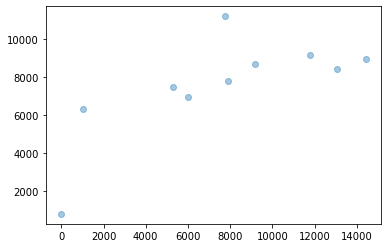

In [168]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_predict, alpha=0.4)

In [169]:
print(mlr.coef_)

[ 8.54106384e+01  2.71702155e+01  7.58686400e+02  9.70030011e+03
  2.15152052e+04  1.16129914e+02  1.46888229e+01 -3.57428995e+04]


In [170]:
print(mlr.score(x_train, y_train))

0.503840829421415


In [183]:
#split안하고 multiple linear regression
import statsmodels.api as sm
model = sm.OLS(y, x).fit()
print_model = model.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                              27.80
Date:                Fri, 06 Nov 2020   Prob (F-statistic):                    2.05e-14
Time:                        14:46:17   Log-Likelihood:                         -478.64
No. Observations:                  50   AIC:                                      973.3
Df Residuals:                      42   BIC:                                      988.6
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
inTp          17.1844    178.454      0.096      0.924    -342.951     377.320
inHd          40.3666     33.966      1.188      0.241     -28.179     108.912
otmsuplyqy   690.5318    406.006      1.701      0.096    -128.822    1509.886
cunt        6681.5646   6421.898      1.040      0.304   -6278.351    1.96e+04
ph         -3660.4469   1.42e+05     -0.026      0.980    -2.9e+05    2.83e+05
outTp        197.2041    124.913      1.579      0.122     -54.881     449.289
inCo2          2.7259      3.825      0.713      0.480      -4.993      10.445
ec           4.22e+04   3.37e+05      0.125      0.901   -6.38e+05    7.22e+05
==============================================================================
Omnibus:                        6.832   Durbin-Watson:                   0.638
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                7.184
Skew:                          -0.497   Prob(JB):                       0.0275
Kurtosis:                       4.569   Cond. No.                     3.05e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""